In [1]:
%matplotlib TkAgg

import matplotlib.pyplot as plt
import mne
import numpy as np
import scipy
from scipy.signal import butter, sosfilt, freqs
import sys
import lzma

In [2]:
def standardizeMatrix(matrixOriginal):
    matrix = np.copy(matrixOriginal)

    floatType = type(matrix[0,0])
    rows, cols = matrix.shape
    matrix = matrix.astype(np.float64)
    
    for i in range(rows):
        mu = np.mean(matrix[i,:])
        sigma = np.std(matrix[i,:])
        matrix[i,:] = (matrix[i,:] - mu) / sigma
    return matrix.astype(floatType)


def elimPeaks(filteredMatrix, sigmaThreshold, sampleHalfWidthElim, sampleMinGap):

    standardizedMatrix = standardizeMatrix(filteredMatrix)
    peakList = []
    nChannel, nSample = standardizedMatrix.shape
    
    for i in range(nChannel):
        for j in range(nSample):
            if np.abs(standardizedMatrix[i,j]) > sigmaThreshold:
                peakList.append(j)
    peakList = list(set(peakList))
    peakList.sort()

    intervalList = [(thisPeak - sampleHalfWidthElim, thisPeak + sampleHalfWidthElim) for thisPeak in peakList]

    mergedIntervalList = [intervalList[0]]
    for i in range(1, len(intervalList)):
        currentInterval = mergedIntervalList[-1]
        nextInterval = intervalList[i]
        if currentInterval[1] + sampleMinGap >= nextInterval[0]:
            mergedIntervalList[-1] = (currentInterval[0], nextInterval[1])
        else:
            mergedIntervalList.append(nextInterval)
        
    startIndex = 0
    matrixList = []
    for i in range(0, len(mergedIntervalList)):
        intervalStart, intervalEnd = mergedIntervalList[i]
        thisMatrix = np.copy(filteredMatrix[:, startIndex:intervalStart])
        matrixList.append(thisMatrix)
        startIndex = intervalEnd + 1

    return matrixList, mergedIntervalList

In [3]:
filename = 'SVD001.edf'
raw = mne.io.read_raw_edf('G:/My Drive/NeuroResearch/Data/eegCompress/ExampleLTMFiles/' + filename)

Extracting EDF parameters from G:\My Drive\NeuroResearch\Data\eegCompress\ExampleLTMFiles\SVD001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


C:\Users\jetti\AppData\Local\Temp\ipykernel_37832\626497673.py:2: RuntimeWarning: Omitted 9 annotation(s) that were outside data range.
  raw = mne.io.read_raw_edf('G:/My Drive/NeuroResearch/Data/eegCompress/ExampleLTMFiles/' + filename)


In [4]:
print(raw)
print(raw.info)

<RawEDF | SVD001.edf, 46 x 1276416 (4986.0 s), ~39 KiB, data not loaded>
<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, F7, T7, P7, O1, F3, C3, P3, A1, Fz, Cz, Fp2, F8, T8, P8, ...
 chs: 46 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 128.0 Hz
 meas_date: 2001-01-01 04:46:55 UTC
 nchan: 46
 projs: []
 sfreq: 256.0 Hz
 subject_info: <subject_info | his_id: SVD001>
>


In [5]:
goodChannels = ['Fp1','F3','C3','P3','O1','Fp2','F4','C4','P4','O2','F7','T7','P7','F8','T8','P8','Fz','Cz','Pz']

In [6]:
sigmaThreshold = 8
sampleHalfWidthElim = 128
sampleMinGap = 256

chanList = mne.pick_channels(raw.info['ch_names'], goodChannels)
dataArray = raw.get_data()[chanList]

#sos = butter(30, [1,lowPass], 'bandpass', fs=256, output='sos')
#dataFiltered = sosfilt(sos, data, -1)

dataList, intervalList = elimPeaks(dataArray, sigmaThreshold, sampleHalfWidthElim, sampleMinGap)

In [10]:
dataList[7].shape

(19, 1100367)

Creating RawArray with float64 data, n_channels=19, n_times=1100367
    Range : 0 ... 1100366 =      0.000 ...  4298.305 secs
Ready.


Using matplotlib as 2D backend.


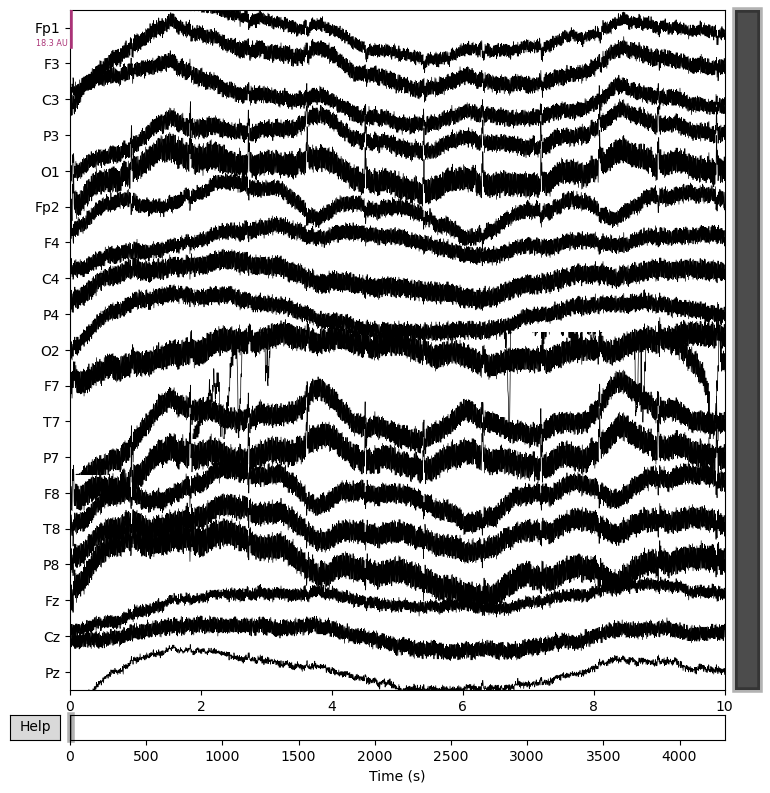

In [8]:
#tempMatrix = tempBlock
tempMatrix = block
#tempMatrix = reconstructBlock

info = mne.create_info(goodChannels, 256)
tempRaw = mne.io.RawArray(tempMatrix, info)
tempRaw.plot()

# Scratch

In [7]:
np.savez_compressed('G:/My Drive/NeuroResearch/Data/eegCompress/processedData/' + 'elimPeaks' + filename[0:-4], *dataList)

In [ ]:
mne.export.export_raw('G:/My Drive/NeuroResearch/Data/eegCompress/processedData/decompressed.edf', tempRaw)

In [ ]:
np.save('G:/My Drive/NeuroResearch/Data/eegCompress/processedData/' + filename[0:-4], data)

In [ ]:
blockIndex = 7
numChannel = 19

block = dataList[blockIndex]
numBytesInOriginalData = 8

factor = 10**6
newType = np.int8

mySize = 0
reconstructBlock = np.zeros_like(block)
for chanIndex in range(numChannel):
    chan = block[chanIndex,:]

    chanDiff = np.diff(chan) * factor
    chanDiffNewType = np.round(chanDiff).astype(newType)

    myCompress = lzma.compress(chanDiffNewType, preset = 9)
    #myDecompress = lzma.decompress(myCompress)
    #myDecompress = [i if i < 128 else (i - 256) for i in myDecompress]

    first = (chan[0] * factor).astype(newType)
    chanReconstruct = np.insert(np.cumsum(chanDiff) + first, 0, first)
    reconstructBlock[chanIndex,:] = np.copy(chanReconstruct)

    mySize = mySize + sys.getsizeof(myCompress)
    
# calculate compression via bytes
print((len(chan) * numBytesInOriginalData * numChannel)/ mySize)